---
##### ***Name : Ashuwin P***
##### ***Register No : 3122 22 5002 013***
##### ***Course : UIT2721 Deep Learning Concepts and Architectures***
##### ***Exercise : 5***
##### ***Dataset : OCT2017 (50%)***
---

In [27]:
import numpy as np
from keras import backend as K
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [6]:
model = load_model('oct_inception_model.h5')

In [9]:
# Set the image generator
eval_datagen = ImageDataGenerator(rescale=1./255)
eval_dir = '../OCT2017/val'
eval_generator = eval_datagen.flow_from_directory(eval_dir, target_size=(299, 299), \
                                                    batch_size=32, class_mode='categorical')

Found 8 images belonging to 2 classes.


In [11]:
# Evaluate the model for a small set of images
loss = model.evaluate(eval_generator, steps=10)
out = {}
for index, name in enumerate(model.metrics_names):
    print(name, loss[index])  

d:\SEM7\UIT2721 Deep Learning\Lab\dl\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0129
loss 0.012875651940703392
compile_metrics 1.0


d:\SEM7\UIT2721 Deep Learning\Lab\dl\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
# Utility functions
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
# Preprocess the input
# Rescale the values to the same range that was used during training 
def preprocess_input(x):
    x = img_to_array(x) / 255.
    return np.expand_dims(x, axis=0) 

In [14]:
# Predict an image
def predict_image(im):
    x = preprocess_input(im)
    pred = np.argmax(model.predict(x))
    return pred, classes[pred]

# Prediction for an image path in the local directory
def predict_from_image_path(image_path):
    return predict_image(load_img(image_path, target_size=(299, 299)))

In [35]:
def find_last_conv_layer(model):
    # Traverse layers in reverse to find the last Conv2D
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

In [38]:
def grad_CAM(image_path, model, last_conv_layer_name="conv2d_94"):
    # Load and preprocess image
    img = load_img(image_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.inception_v3.preprocess_input(x)

    # Forward pass to get predictions
    preds = model.predict(x)
    class_index = np.argmax(preds[0])

    # Build a model that outputs the last conv feature map + predictions
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [last_conv_layer.output, model.output]
    )

    # Record gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x)
        loss = predictions[:, class_index]

    # Get gradients of loss wrt conv layer
    grads = tape.gradient(loss, conv_outputs)[0]

    # Global average pooling on gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Weight the feature maps by pooled grads
    conv_outputs = conv_outputs[0]
    conv_outputs = conv_outputs * pooled_grads

    # Compute heatmap
    heatmap = tf.reduce_mean(conv_outputs, axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    # Superimpose heatmap on original image
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Show result
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [32]:
print(predict_from_image_path(r'..\OCT2017\val\DME\DME-9583225-2.jpeg'))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
(np.int64(0), 'CNV')


In [36]:
last_conv_layer_name = find_last_conv_layer(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


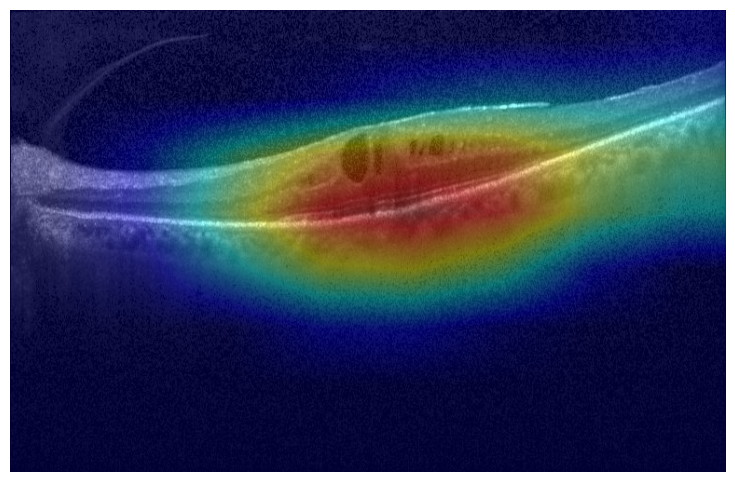

In [39]:
grad_CAM(r'..\OCT2017\val\DME\DME-9583225-2.jpeg', model, last_conv_layer_name)